In [1]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
import cPickle as pickle
import exputil
import time
import pandas as pd
import seaborn as sns
import sklearn.metrics

Populating the interactive namespace from numpy and matplotlib


(1600, 1600)


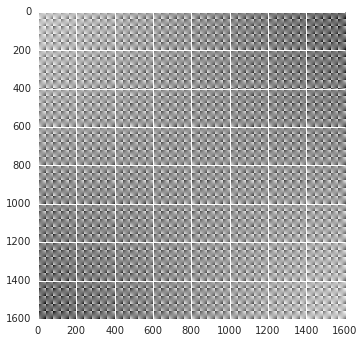

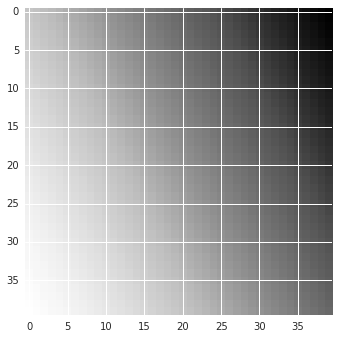

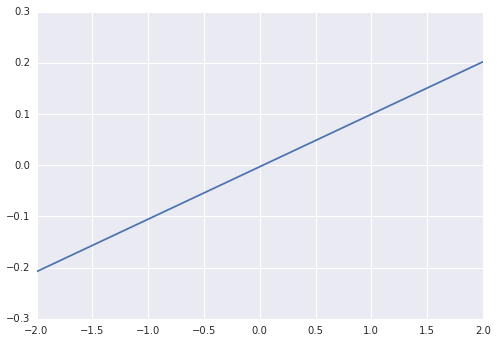

In [2]:
import kernels
reload(kernels)
reload(exputil)

kern_func = kernels.inner_product() # , 1.0) # , 3.0)

kern_f = exputil.make_kern_f(kern_func)
N = 40
x = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, x)
points = np.array([xv.flatten(), yv.flatten()]).T
#points = np.meshgrid()
r  = kern_f(points, [2, -1])
print r.shape
pylab.imshow(r, interpolation='nearest')
pylab.figure()
pylab.imshow(r[N**2/2 + N/2].reshape((N, N)), interpolation='nearest')
pylab.figure()
pylab.plot(x, r[N**2/2 + N/2].reshape((N, N))[N/2])

<matplotlib.colorbar.Colorbar instance at 0x7f973dd22d40>

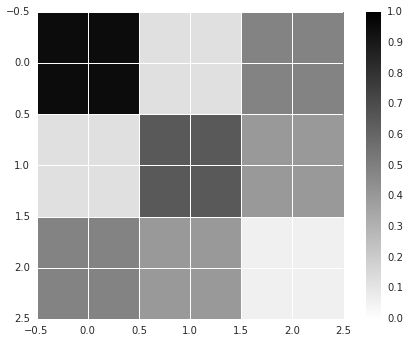

In [333]:
import synthetic
reload(synthetic)

#G = synthetic.stochastic_block_model(3, 100, manual_weights = {
#                                                               (1, 1): 0.2,
#                                                                (0, 2): 0.2, 
#                                                               (2, 0): 0.2},pmin=0.01)
G = synthetic.stochastic_block_model(3, 100, pmin=0.01, symmetric=True)

import networkx as nx
obs = synthetic.get_adj_mat(G)
pylab.imshow(G.graph['latent_mat'], interpolation='nearest', cmap=pylab.cm.gray_r, vmin=0, vmax=1)
pylab.colorbar()

In [334]:
assignments = [G.node[g]['block'] for g in G.nodes()]
ai = np.argsort(assignments).flatten()

(100, 100)


<matplotlib.colorbar.Colorbar instance at 0x7f973b5e1dd0>

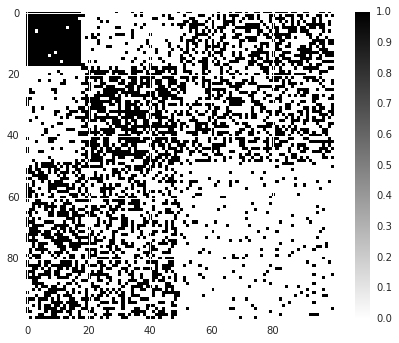

In [335]:
reload(sgd)
import losses
reload(losses)
N = len(obs)
D = 4

lossobj = losses.Logistic(0.5)

print obs.shape

obs_frac = 1.1
obsvalid = np.random.rand(*obs.shape) < obs_frac

obs_sorted = obs[ai]
obs_sorted = obs_sorted[:, ai]

pylab.imshow(obs_sorted, interpolation='nearest', cmap=pylab.cm.gray_r)
pylab.colorbar()

In [336]:
### 
reload(sgd)
ITERS = 10000
#np.random.seed(16)
xinit = np.random.normal(0, 0.1, (N, D))
U, s, V = np.linalg.svd(obs)
theta_init = np.zeros(D) # random.dirichlet(np.ones(D)) 
xinit = U[:, :D]
t1 = time.time()
res = sgd.run_bfgs(kern_func, lossobj.cost(), 
                   xinit, theta_init, obs, obsvalid,
                   iters=ITERS, #ftol=1e-14, 
                   #gtol=1e-14,
                   theta_inference=True)
print "total time was", time.time() - t1

total time was 29.7947330475


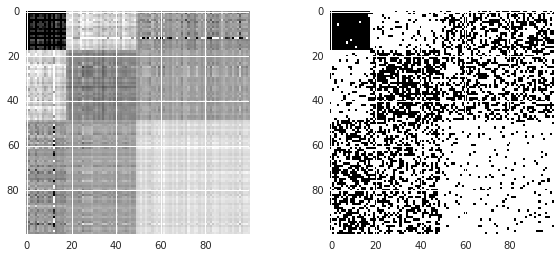

In [337]:
x_est = res['x_est']
theta_est = res['theta_est']
est_params = kern_f(x_est, theta_est)
ep =est_params[ai]
ep = ep[:, ai]
fig = pylab.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

ax.imshow(ep, interpolation='nearest', vmin=0, vmax=1)
ax = fig.add_subplot(1, 2, 2)

ax.imshow(obs_sorted, interpolation='nearest', cmap=pylab.cm.gray_r)
#ax.imshow(G.graph['latent_mat'], interpolation='nearest',  vmin=0, vmax=1)


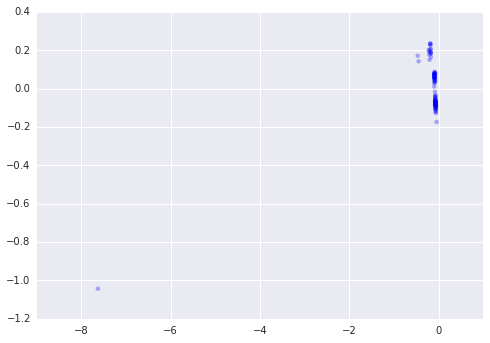

In [339]:

pylab.scatter(x_est[:, 0], x_est[:,2], edgecolor='none', alpha=0.3)
#pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r', edgecolor='none')


In [29]:
import pandas as pd
pd.crosstab(true_vals, est_vals)

NameError: name 'true_vals' is not defined

In [ ]:


pylab.figure(figsize=(20, 4))
pylab.plot(true_vals, c='k', label='true')
pylab.scatter(range(len(est_vals)), est_vals,  c='r', alpha=1, label='estimated')
#pylab.ylim(-0.5, 1.5)
#pylab.xlim(0, N)
pylab.legend()

In [ ]:
### 
reload(sgd)
reload(exputil)

for ITERS in [1000, 2000, 5000, 10000, 20000, 50000, 100000]:
    

    alpha = 0.1
    kfold_cv = 10
    xinit = np.random.normal(0, 5, (N, D))
    
    res = exputil.run_cv_exp(kern_func, lossobj.cost(), 
                   xinit, obs, lossobj.obs_forward, kfold_cv, batch_size=40, 
                   alpha=alpha, iters=ITERS, use_adagrad=True, seed=None, 
                   verbose=True, verbose_iter=1000, folds_to_run=1)



    fpr, tpr, th = sklearn.metrics.roc_curve(res[0]['true_vals'],
                                             res[0]['est_params'])
    pylab.plot(fpr, tpr, label=ITERS)
pylab.legend(loc='lower right')

In [ ]:
### 
reload(sgd)
reload(exputil)

ITERS = 10000    

alpha = 0.1
kfold_cv = 10
xinit = np.random.normal(0, 5, (N, D))
res = exputil.run_cv_exp(kern_func, lossobj.cost(), 
               xinit, obs, lossobj.obs_forward, kfold_cv, batch_size=40, 
               alpha=alpha, iters=ITERS, use_adagrad=True,  
               verbose=False, verbose_iter=1000)


for ri, r in enumerate(res):
    fpr, tpr, th = sklearn.metrics.roc_curve(r['true_vals'],
                                             r['est_params'])
    pylab.plot(fpr, tpr, c='k', alpha=0.3)
pylab.legend(loc='lower right')